In [1]:
# Usual suspect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import sys
from typing import List
sys.path.insert(1, '../muograph/')

![alternative text](../images/muograph_logo.png)


<h1><center>POCA tutorial</center></h1>

Point Of Closest Approach computation is handled by the `POCA` class of the POCA.py file.

First we define the Volume of interest using the `VolumeInterest` class.

In [2]:
from volume.Volume_Interest import VolumeInterest

VOI = VolumeInterest(position = [0,0,835],
                     dimension=[400,1000,300],
                     voxel_width=20)

Then we apply the tracking routine. 

In [3]:
from tracking.Tracking import Tracking
from utils.read_file import hits_csv_to_tensor

hits,E = hits_csv_to_tensor(n_event=50000)
tracks = Tracking(hits=hits,voi=VOI,E=E)


Tracking in progress


Tracking done
Scattering angles computation done


In [4]:
from reconstruction.POCA import POCA

poca = POCA(output_dir="",tracks=tracks)
poca


Total # event =  50000
# event after removing low theta events =  18750




Assigning voxel to each POCA point:


DONE


POCA points:
Total # event = 50000
# POCA dtheta > 0.01 deg = 18750
# POCA in VOI = 13792

## 1 - POCA points: location

We can now apply some cuts and plot the POCA points location.

***NB:*** Here we only consider the POCA points position, without looking at the scattering amplitude.

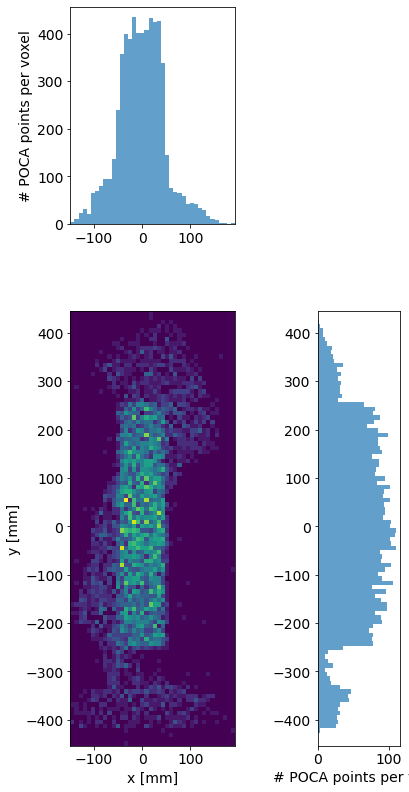

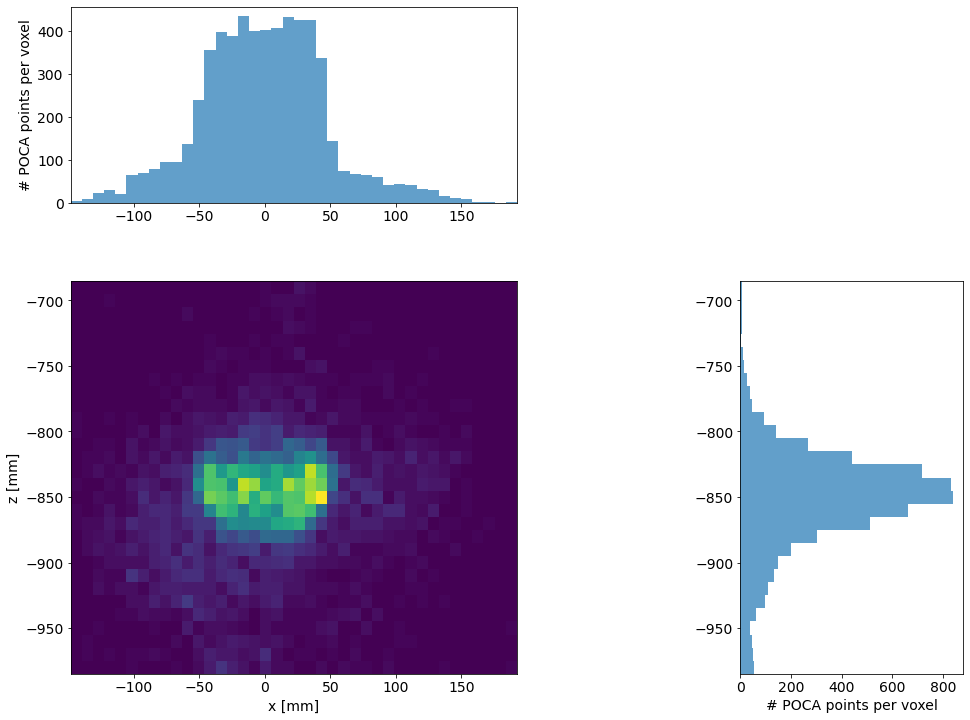

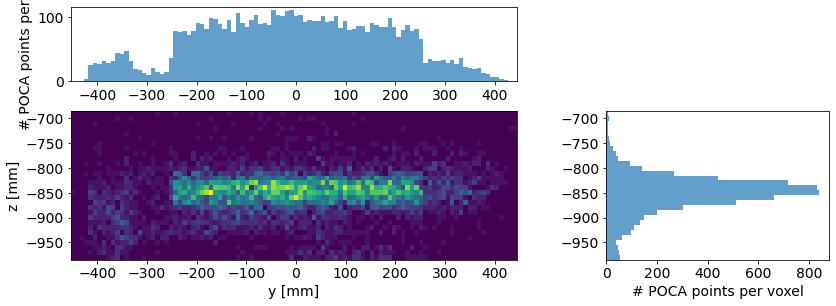

In [5]:
from plotting.Plotting import plot_POCA_points_multi_projection
import math
# ploting only POCA points for which dtheta > .5 deg 
plot_POCA_points_multi_projection(POCA_points = poca.POCA_points,
                                  mask = poca.tracks.dtheta*180/math.pi>.5,
                                  binning_xyz=VOI.n_vox_xyz*2)

It is also possible to plot the poca points location for each VOI slice along a given dimension. Here we plot the poca points location in the $x$ and $y$ plane, for each VOI slice along $z$.

/home/geant/Desktop/Muograph/tutorials/../muograph/plotting/Plotting.py:460: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


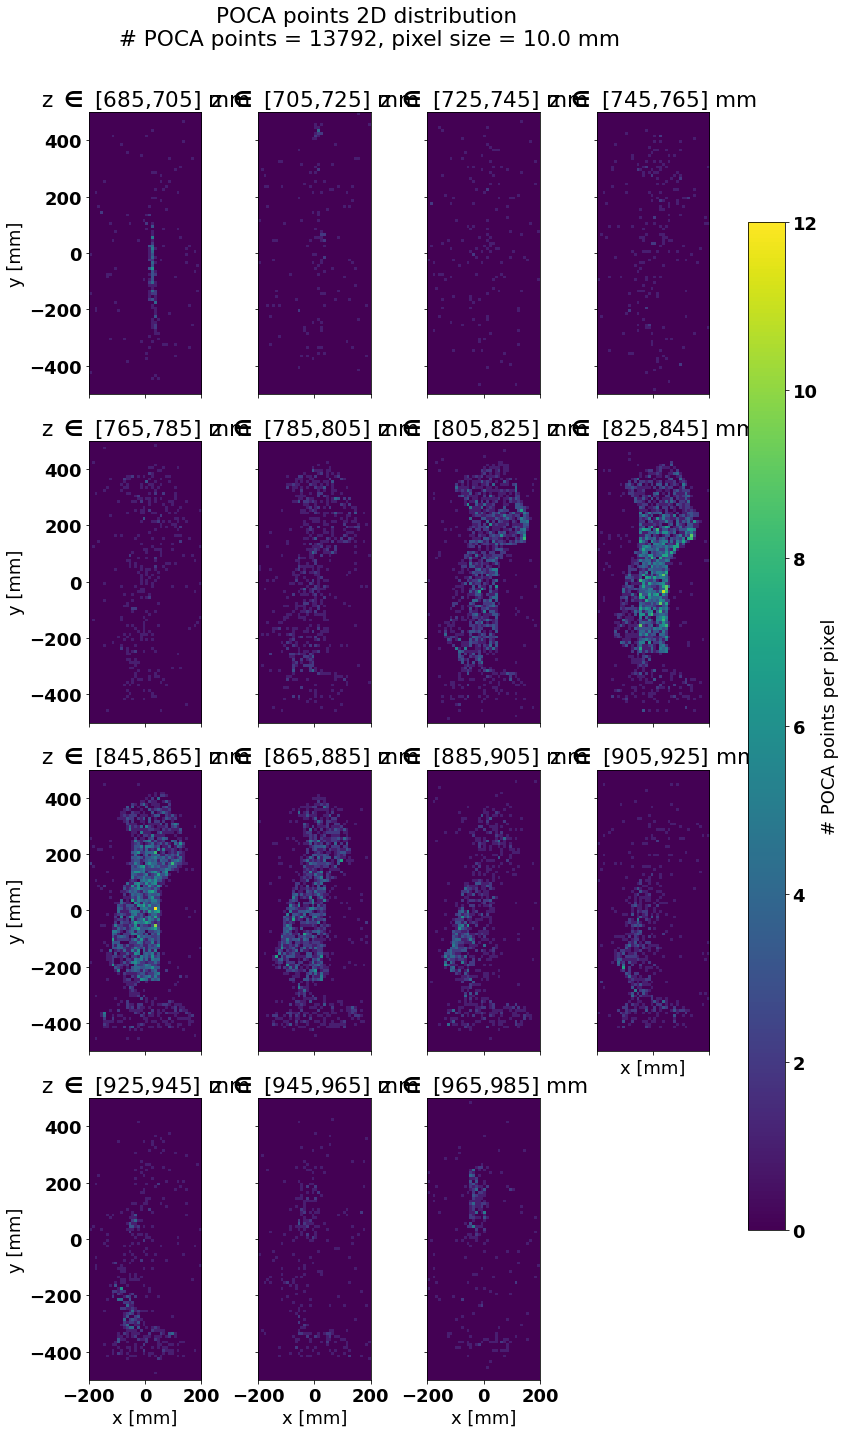

In [6]:
from plotting.Plotting import plot_poca_points_by_voi_slice

plot_poca_points_by_voi_slice(poca_points=poca.POCA_points,
                              VOI=VOI,
                              dim=2, #dim=2: z axis
                              ncols=4, # figure with 4 columns
                              scale_binning=2., # 1 pixel is 1/2 voxel size 
                              filename=None,
                              axis_label_all=False,
                              fontsize=18) #font size

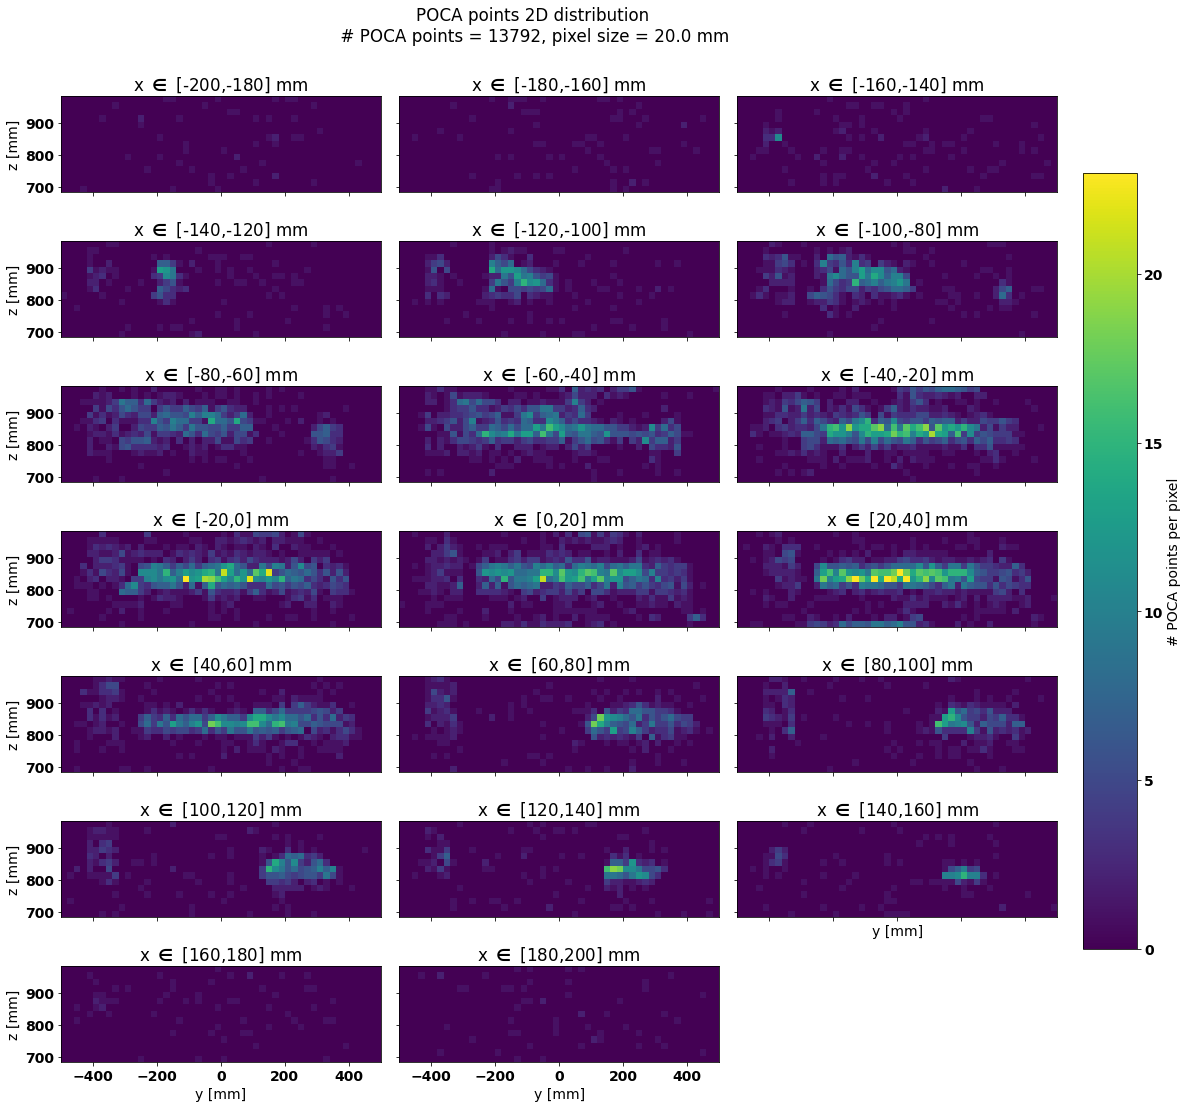

In [7]:
plot_poca_points_by_voi_slice(poca_points=poca.POCA_points,
                              VOI=VOI,
                              dim=0, #dim=2: x axis
                              ncols=3, # figure with 3 columns
                              scale_binning=1., # 1 pixel is 1 voxel size 
                              filename=None,
                              axis_label_all=False,fontsize=14)

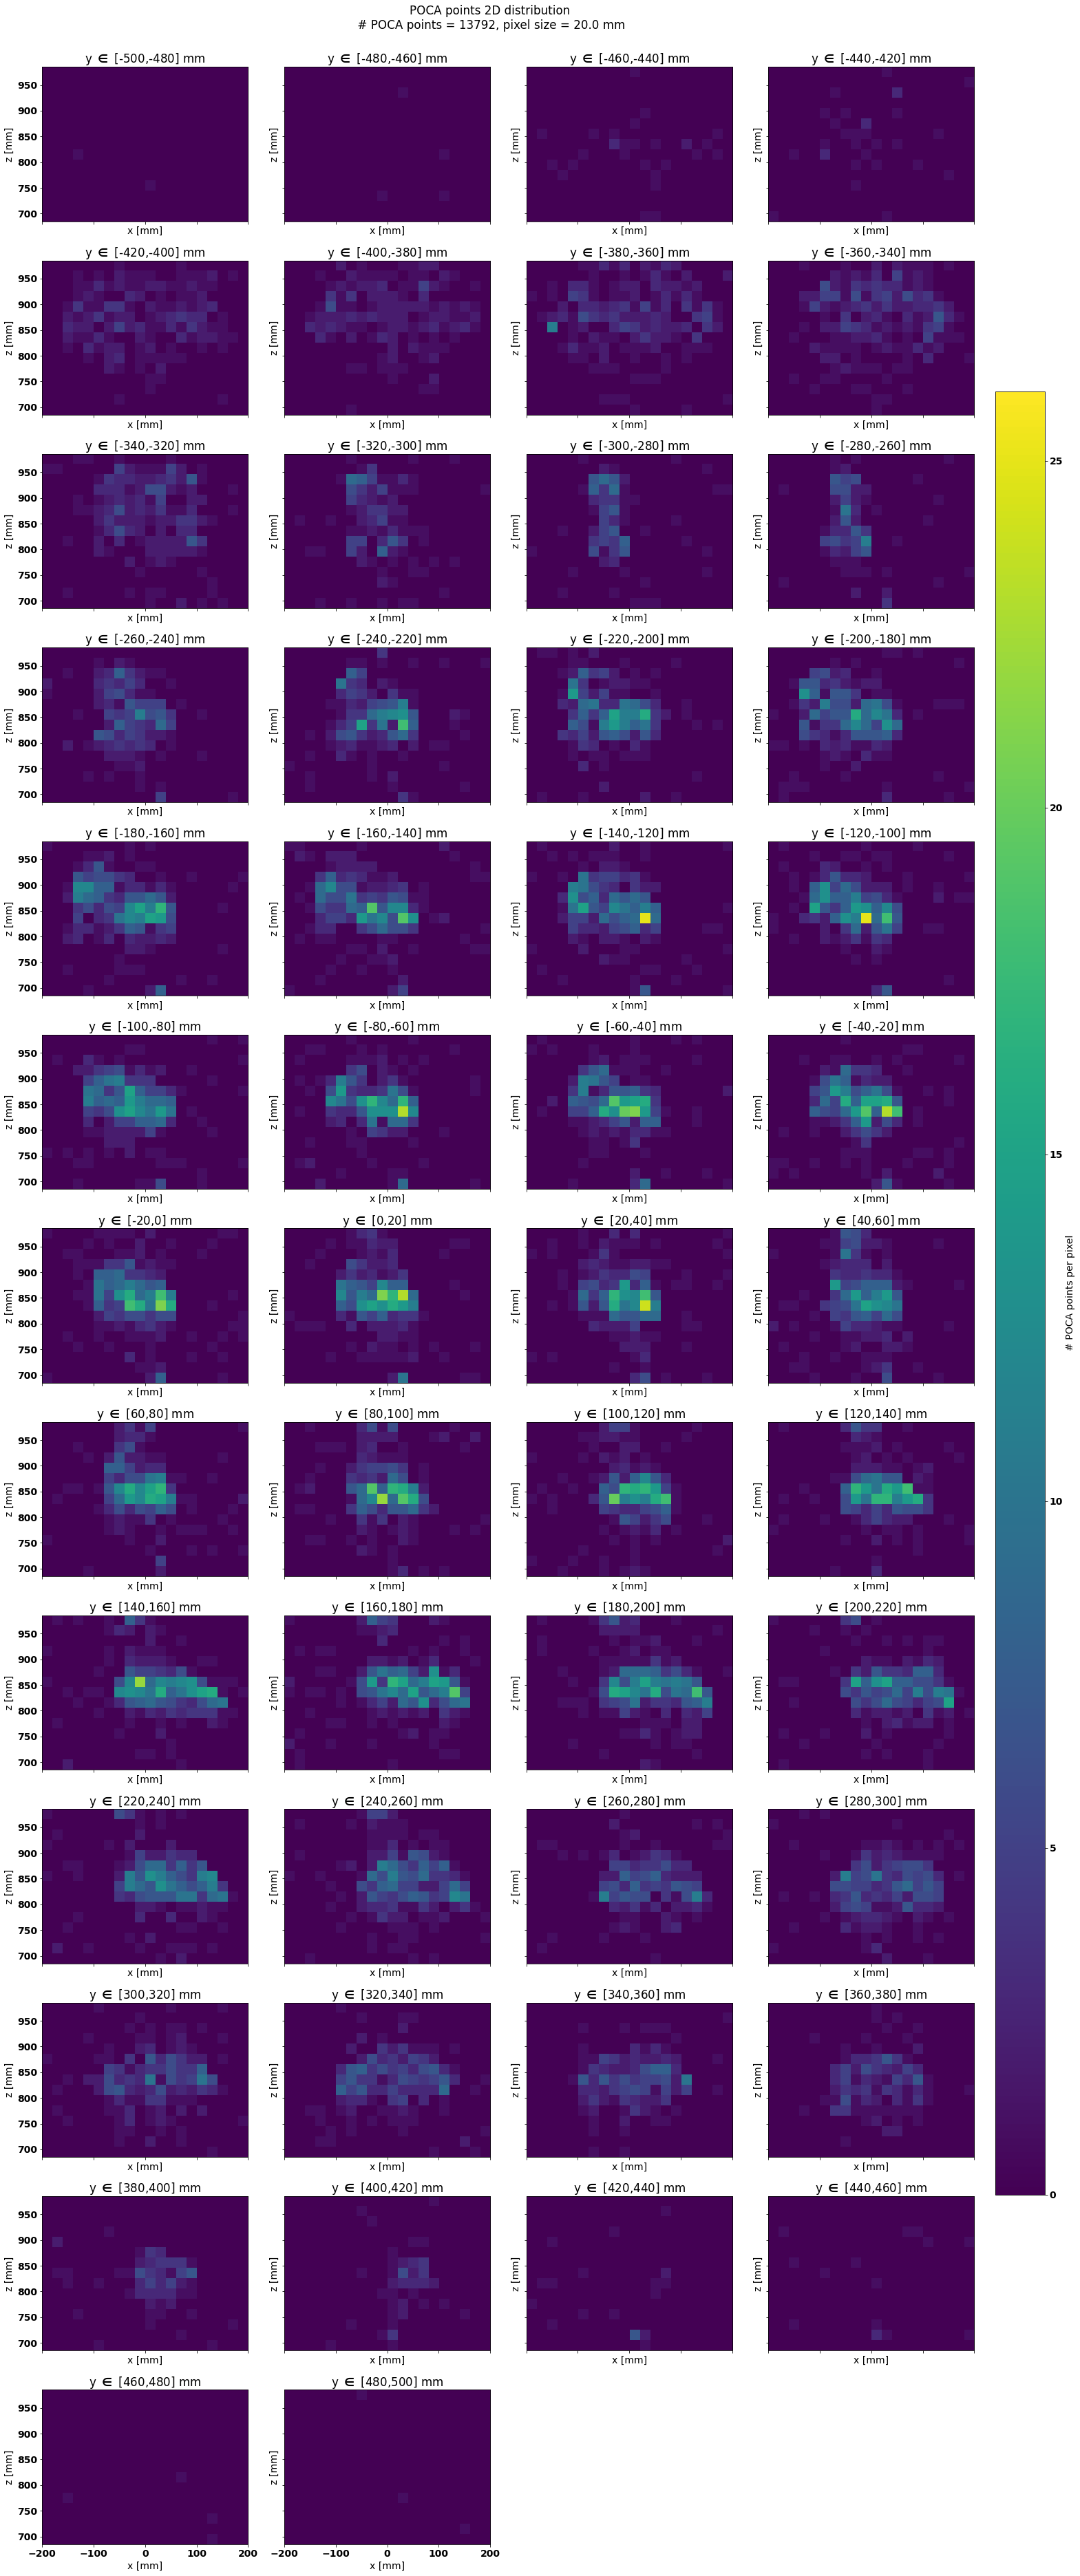

In [8]:
plot_poca_points_by_voi_slice(poca_points=poca.POCA_points,
                              VOI=VOI,
                              dim=1, #dim=2: x axis
                              ncols=4, # figure with 4 columns
                              scale_binning=1., # 1 pixel is 1 voxel size 
                              filename=None,
                              axis_label_all=True,
                              fontsize=14)

## 2- POCA points: location and scattering amplitude

Now that the POCA points are computed, we can apply score to them in order to generate the scattering density map. It is done using the following logic:

- 1/ **Assign** an **empty list** $S_{ijk}$ to **each voxel**.


- 2/ **for each event**:
    - for each POCA points in voxel with indices $i,j,k$:
        
        - **Append** the desired **feature** `score_feature` (scattering angle $d\theta$ in this case) to $S_{ijk}$ **if** the event **satisfies** the **condition**: 
        
        $$d\theta_{min}\:<\:d\theta\:<\: d\theta_{max}$$
        
- 3/ **for each voxel**:
    - Assign a final score `final_scores` to the voxel based on its `score_list`, using the desired function (`rms_list` in this case).
    
    
The `final_scores` tensor can be used to **plot** the **scattering density map** of the VOI, using the `plot_VOI_pred()` method.




Assigning score to voxels:


DONE

Computing final scores:


DONE


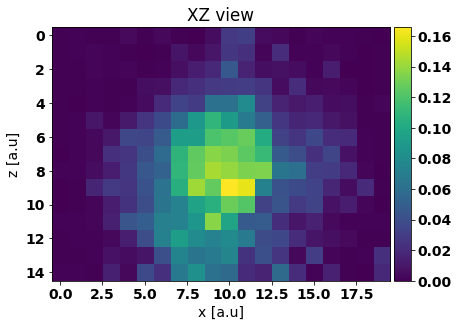

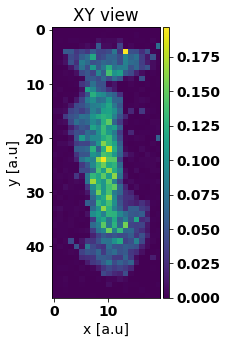

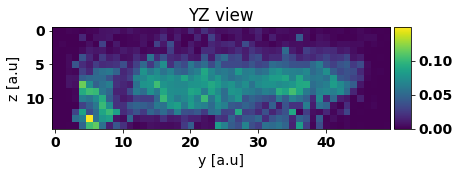

In [9]:
import math
def rms_list(x:List):
    return np.sqrt(np.mean(np.array(x)))

from functools import partial
final_scores = poca.poca_analysis(score_feature=[poca.tracks.dtheta,"dtheta"], 
                                  dtheta_range=[0., math.pi/2], 
                                  score_method=partial(rms_list),
                                  save=True,
                                  plot=True)


Assigning score to voxels:


DONE

Computing final scores:


DONE


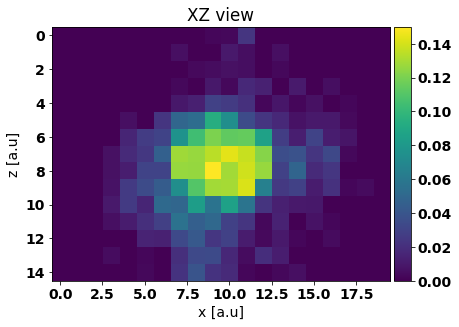

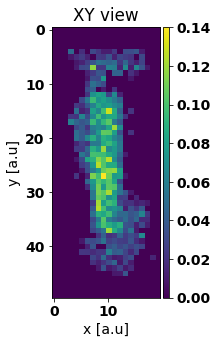

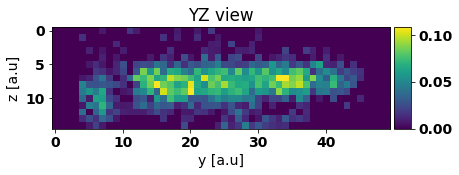

In [10]:
def rms_list_square(x:List):
    return np.mean(np.array(x))

final_scores = poca.poca_analysis(score_feature=[poca.tracks.dtheta,"dtheta"], 
                                  dtheta_range=[1*math.pi/180, 8*math.pi/180], 
                                  score_method=partial(rms_list),
                                  save=True,
                                  plot=True)

It is also possible to plot the scattering density predictions for each VOI slice along a given dimension. Here we plot the the predictions in the $x$ and $y$ plane, for each VOI slice along $z$:

/home/geant/Desktop/Muograph/tutorials/../muograph/plotting/Plotting.py:590: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


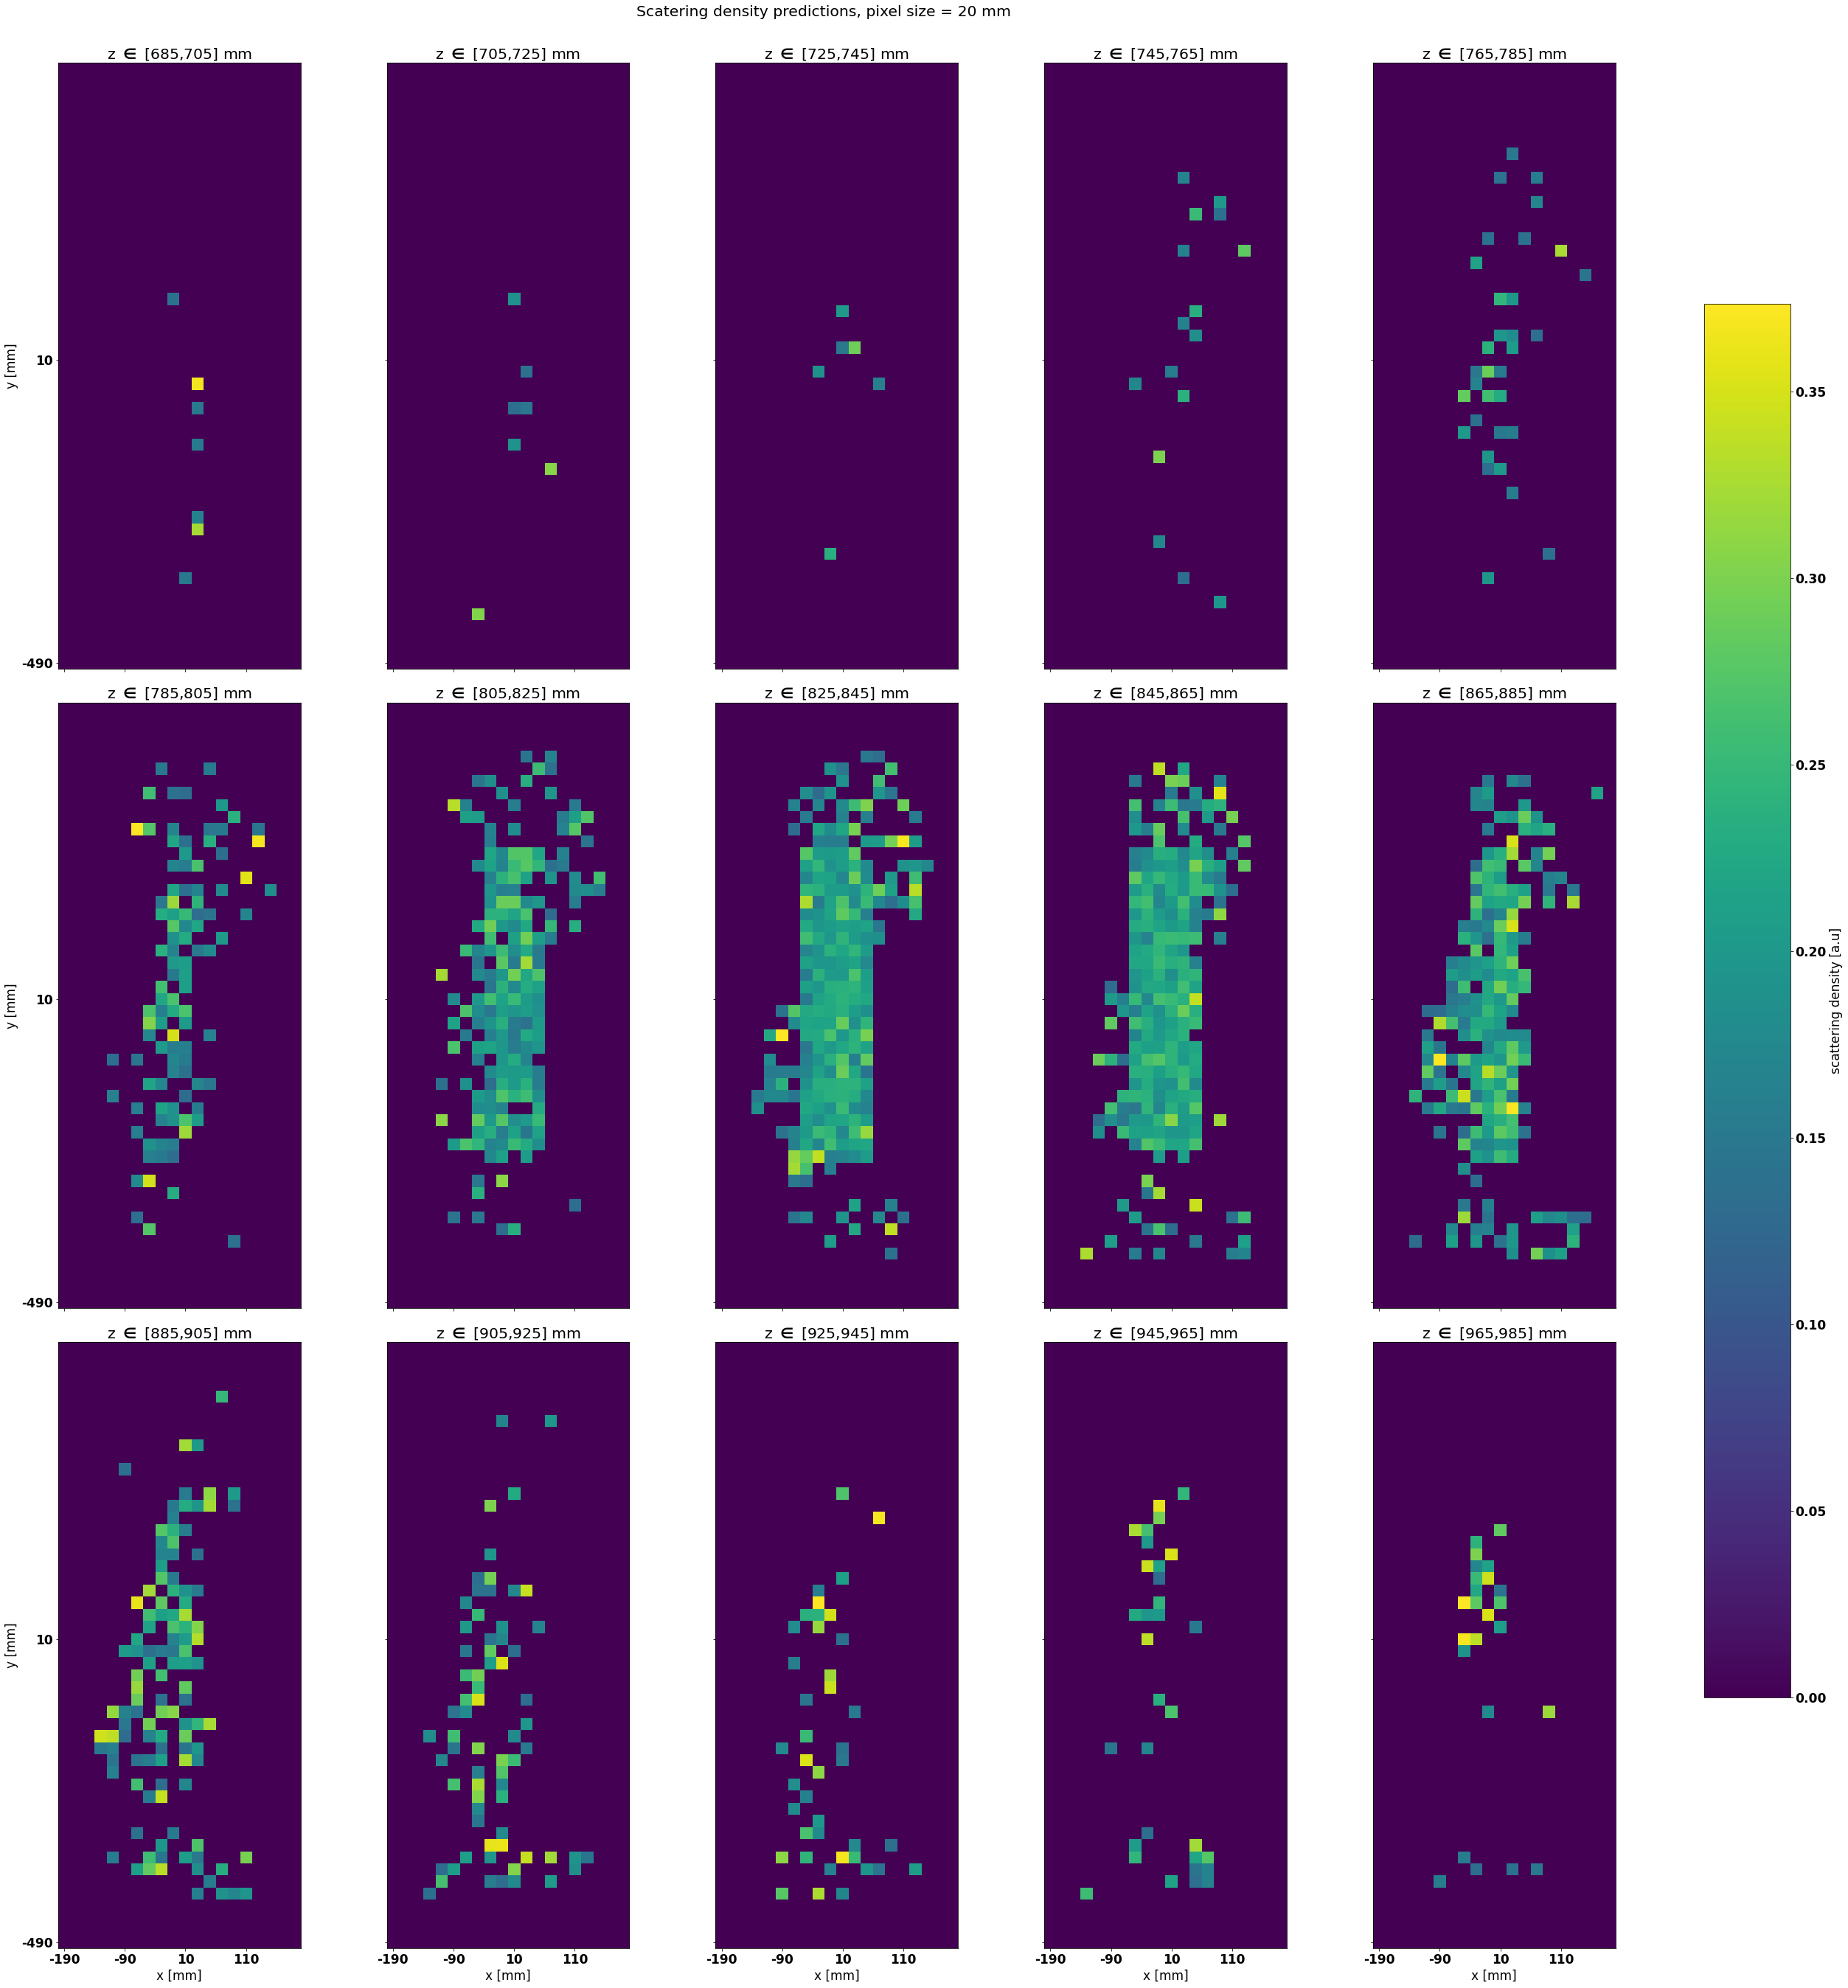

In [11]:
from plotting.Plotting import plot_voi_pred_by_voi_slice

plot_voi_pred_by_voi_slice(preds=final_scores, # predictions
                           VOI=VOI, # Volume of Interest
                           dim=2, # plot z slice
                           ncols=5, # nb columns in figure
                           filename=None, # save figure
                           scale=10.) # figsize

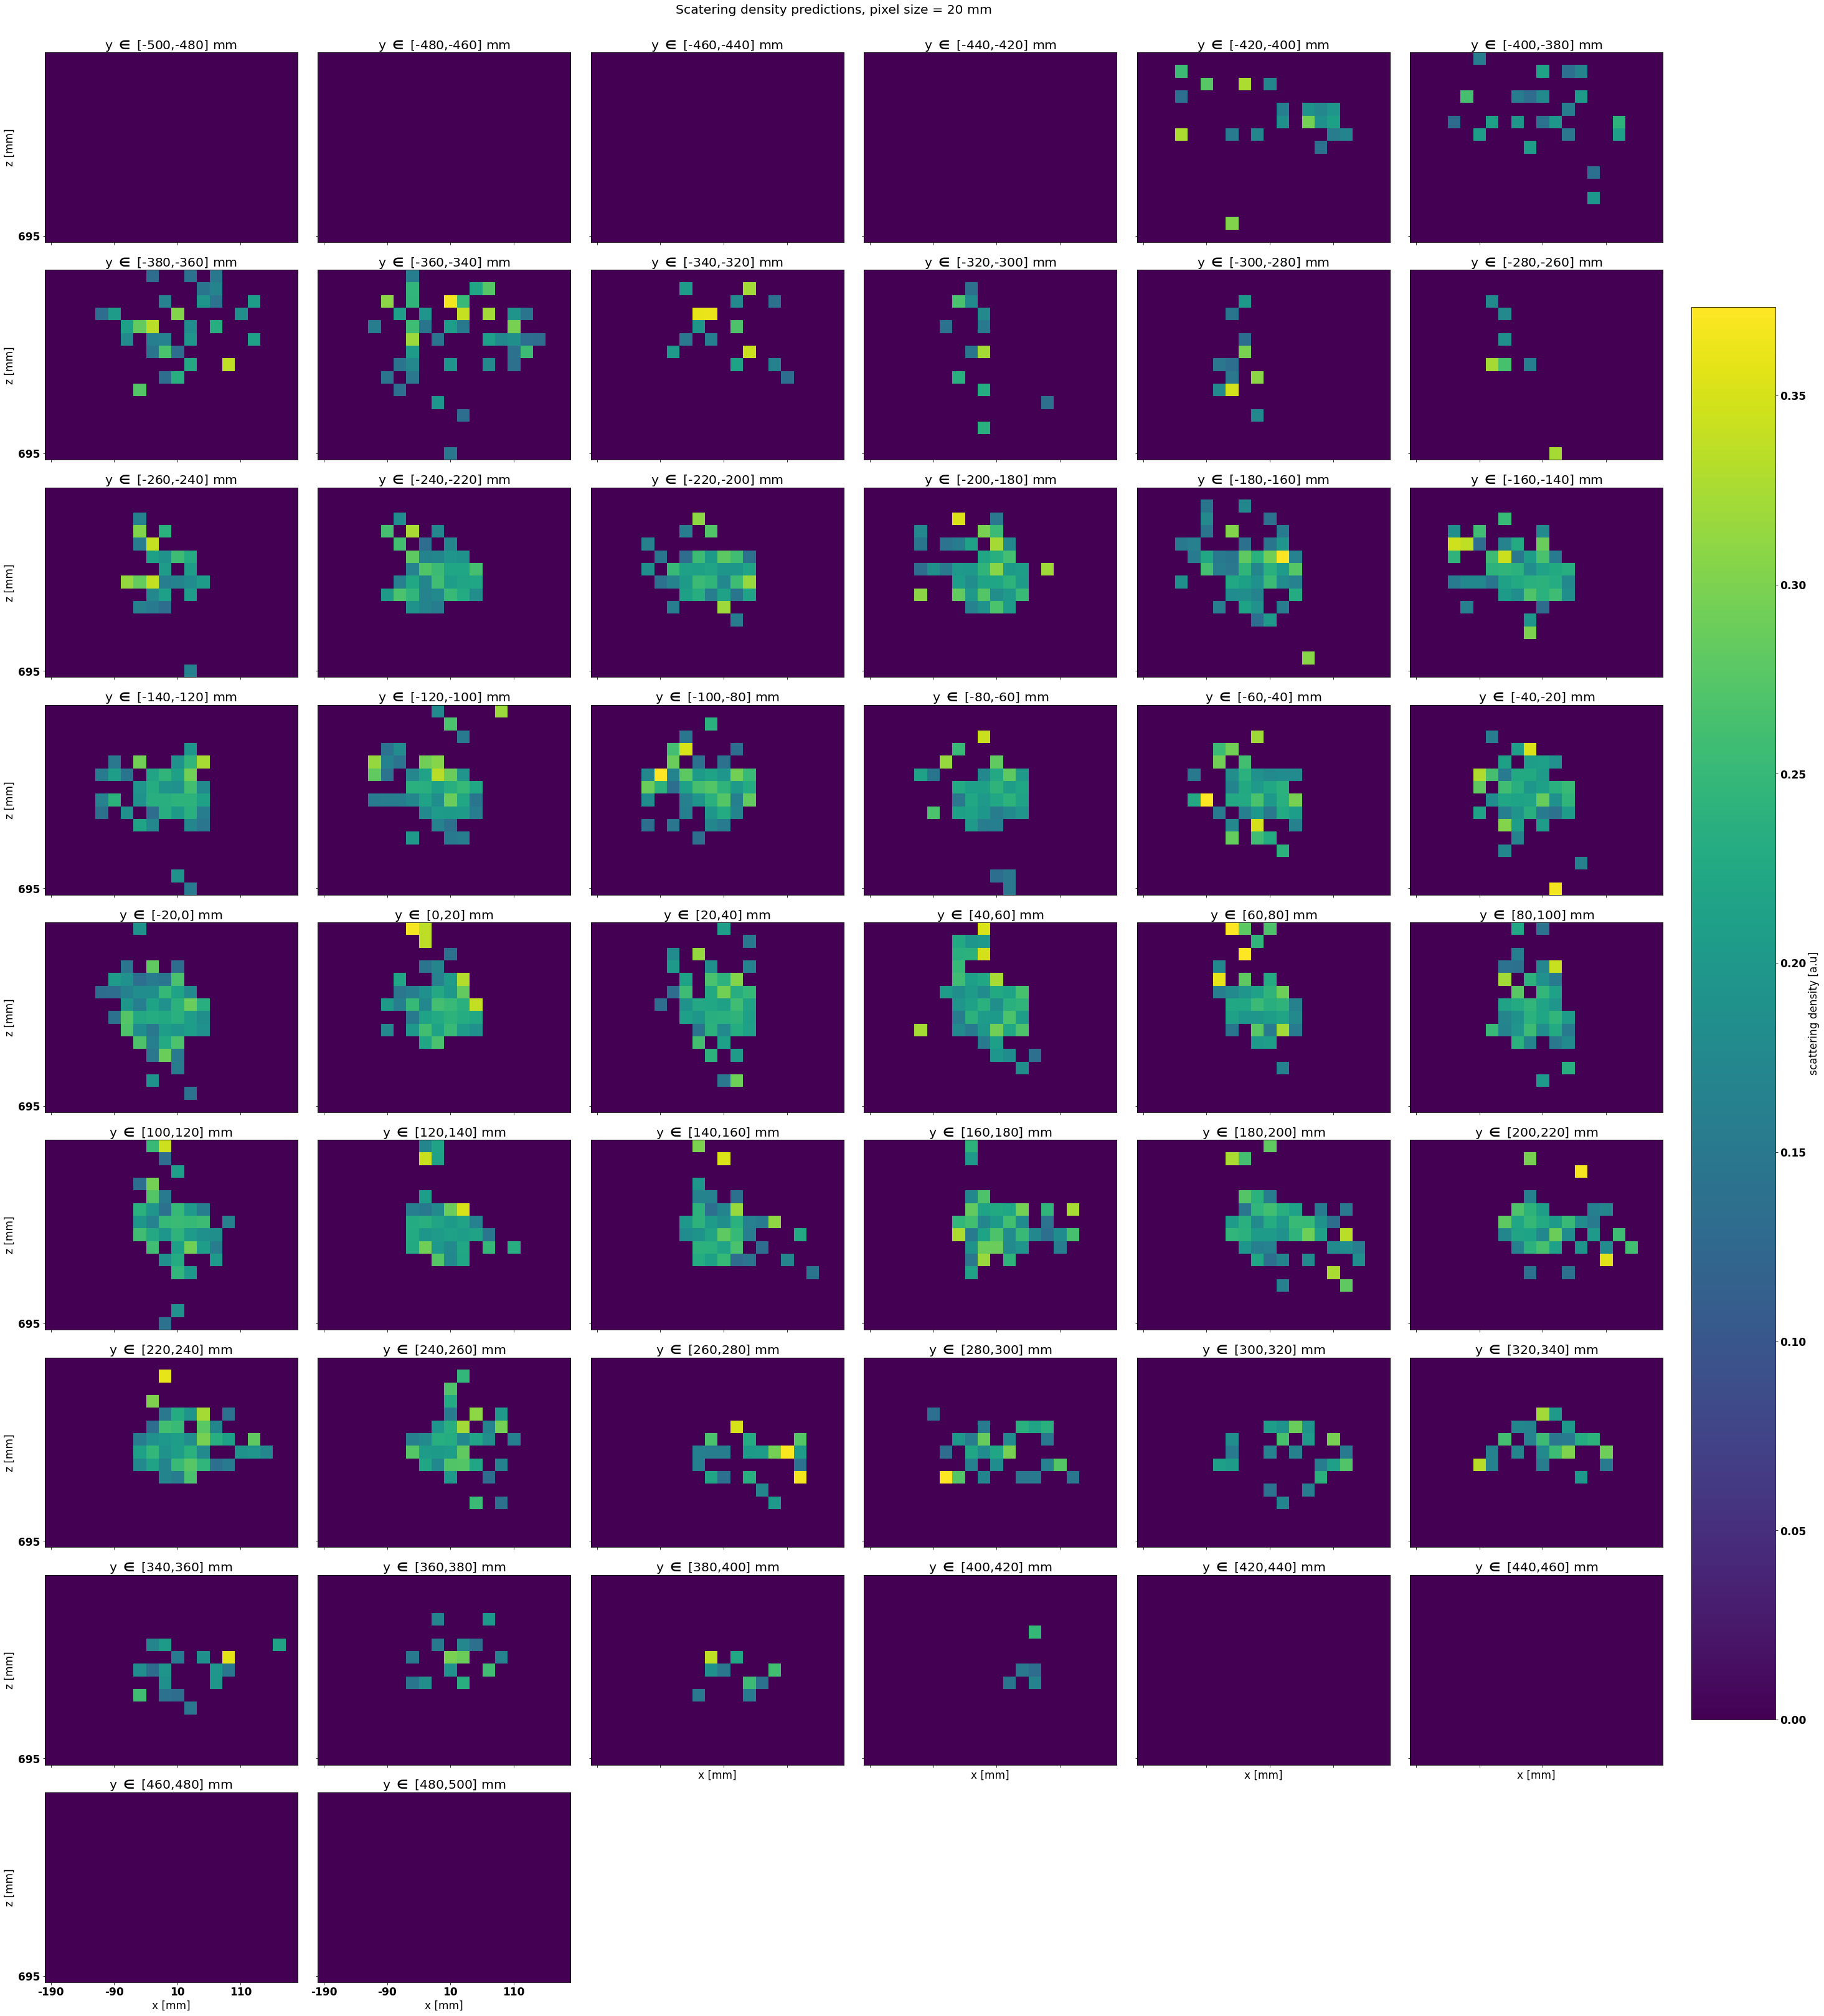

In [16]:
plot_voi_pred_by_voi_slice(preds=final_scores, # predictions
                           VOI=VOI, # Volume of Interest
                           dim=1, # plot y slice
                           ncols=6, # nb columns in figure
                           filename=None, # save figure
                           scale=5.) # figsize

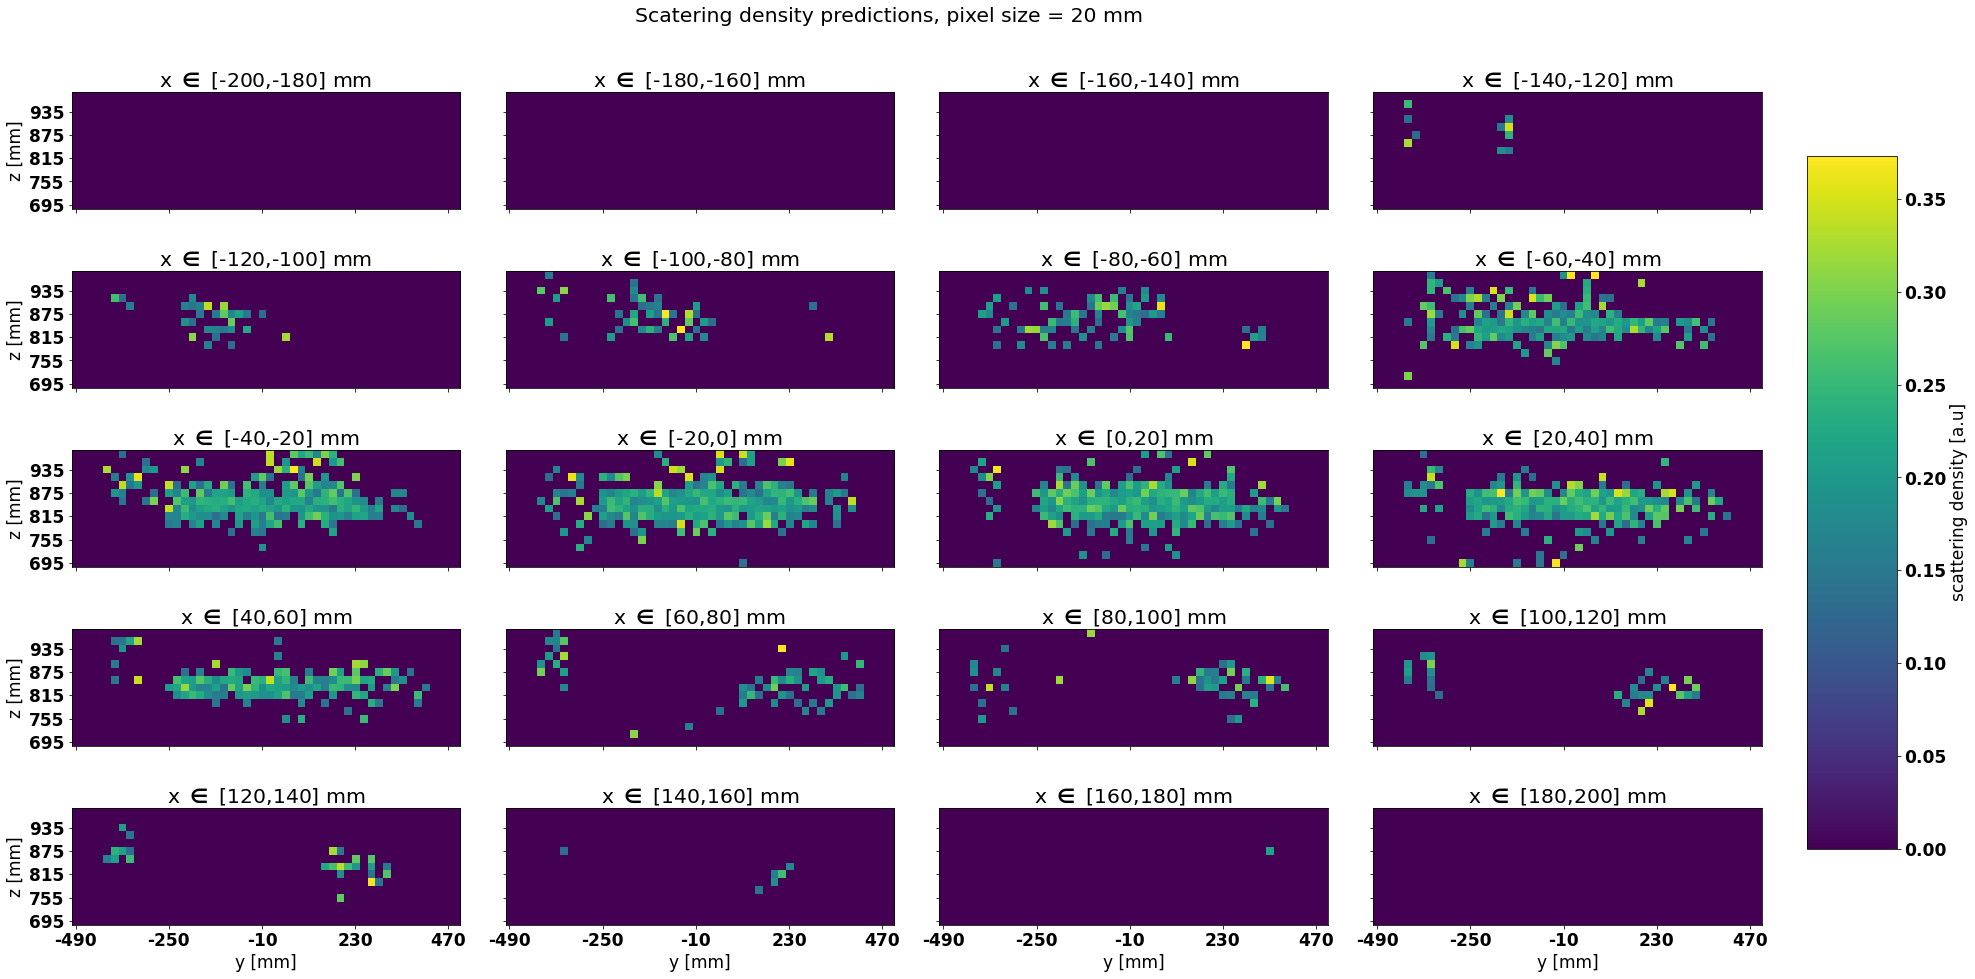

In [15]:
plot_voi_pred_by_voi_slice(preds=final_scores, # predictions
                           VOI=VOI, # Volume of Interest
                           dim=0, # plot x slice
                           ncols=4, # nb columns in figure
                           filename=None, # save figure
                           scale=5.) # figsize